# CS 316 : Introduction to Deep Learning
## Lab 04 :  Linear Regression
### Dr. Abdul Samad

# Overview

Hello, students. We will use Numpy to implement Linear Regression in this lab. We will begin by generating a random dataset and then attempt to learn a linear regression model that fits the data. You will also be introduced to the JAX library.

**Please ensure that you have either a Kaggle or a Google Colab account before beginning this lab.**

# Setup

In [1]:
# Import the required Libraries.
%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
np.random.seed(42)


# Generate Dataset



- Randomly generate $\mathbf{X}\in \mathbb{R}^{1000 \times 2}$
- Use ground truth: weight $\mathbf{w} = [2, -3.4]^\top$ and bias $b = 4.2$
- Generate label by $\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon$
  with noise $\epsilon$ obeying a normal distribution with a mean of 0 and a standard deviation of 0.01. 

In [2]:
num_inputs = 2
num_examples = 1000
true_w = np.array([2,-3.4])
true_b = 4.2
# Random generate features
features = np.random.normal(scale=1, size=(num_examples, num_inputs))
# Compute Xw + b
labels = np.dot(features, true_w) + true_b
# Add randomnly generated noise to Xw + b
labels += np.random.normal(scale=0.01, size=labels.shape)

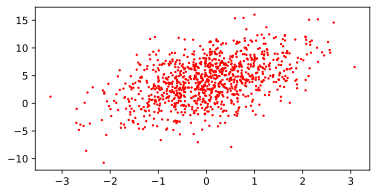

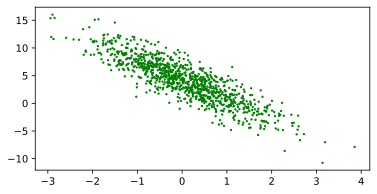

In [3]:
display.set_matplotlib_formats('svg')
marker_size = 2
# X with respect to weight one
plt.figure(figsize=(6, 3))
plt.scatter(features[:,0], labels, marker_size,'red');
# X with respect to weight two
plt.figure(figsize=(6, 3))
plt.scatter(features[:,1], labels, marker_size,'green');

In [4]:
X = features
y = labels
ones = np.ones(shape=(num_examples,1))
# Concatenate a column of ones with X 
X = np.concatenate((X,ones),axis=1)
X.shape,y.shape

((1000, 3), (1000,))

# Basic Components of Linear Regression



*Linear regression* may be both the simplest
and most popular among the standard tools to regression.
Dating back to the dawn of the 19th century,
linear regression flows from a few simple assumptions.
First, we assume that the relationship between
the independent variables $\mathbf{x}$ and the dependent variable $y$ is linear,
i.e., that $y$ can be expressed as a weighted sum
of the elements in $\mathbf{x}$,
given some noise on the observations.
Second, we assume that any noise is well-behaved
(following a Gaussian distribution).



## Sample Problem - House Pricing

Suppose that we wish to estimate the prices of houses (in dollars)
based on their area (in square feet) and age (in years).
To actually develop a model for predicting house prices,
we would need to get our hands on a dataset
consisting of sales for which we know
the sale price, area, and age for each home.
In the terminology of machine learning,
the dataset is called a *training dataset* or *training set*,
and each row (here the data corresponding to one sale)
is called an *example* (or *data point*, *data instance*, *sample*).
The thing we are trying to predict (price)
is called a *label* (or *target*).
The independent variables (age and area)
upon which the predictions are based
are called *features* (or *covariates*). Typically, we will use $n$ to denote
the number of examples in our dataset.
We index the data examples by $i$, denoting each input
as $\mathbf{x}^{(i)} = [x_1^{(i)}, x_2^{(i)}]^\top$
and the corresponding label as $y^{(i)}$.



## Linear Model


The linearity assumption just says that the target (price)
can be expressed as a weighted sum of the features (area and age):

$$\mathrm{price} = w_{\mathrm{area}} \cdot \mathrm{area} + w_{\mathrm{age}} \cdot \mathrm{age} + b.$$

$w_{\mathrm{area}}$ and $w_{\mathrm{age}}$
are called *weights*, and $b$ is called a *bias*
(also called an *offset* or *intercept*).
The weights determine the influence of each feature
on our prediction and the bias just says
what value the predicted price should take
when all of the features take value 0.
Even if we will never see any homes with zero area,
or that are precisely zero years old,
we still need the bias or else we will
limit the expressivity of our model.
Strictly speaking, is an *affine transformation*
of input features,
which is characterized by
a *linear transformation* of features via weighted sum, combined with
a *translation* via the added bias.

Given a dataset, our goal is to choose
the weights $\mathbf{w}$ and the bias $b$ such that on average,
the predictions made according to our model
best fit the true prices observed in the data.
Models whose output prediction
is determined by the affine transformation of input features
are *linear models*,
where the affine transformation is specified by the chosen weights and bias.


In disciplines where it is common to focus
on datasets with just a few features,
explicitly expressing models long-form like this is common.
In machine learning, we usually work with high-dimensional datasets,
so it is more convenient to employ linear algebra notation.
When our inputs consist of $d$ features,
we express our prediction $\hat{y}$ (in general the "hat" symbol denotes estimates) as

$$\hat{y} = w_1  x_1 + ... + w_d  x_d + b.$$

Collecting all features into a vector $\mathbf{x} \in \mathbb{R}^d$
and all weights into a vector $\mathbf{w} \in \mathbb{R}^d$,
we can express our model compactly using a dot product:

$$\hat{y} = \mathbf{w}^\top \mathbf{x} + b.$$


The vector $\mathbf{x}$ corresponds to features of a single data example.
We will often find it convenient
to refer to features of our entire dataset of $n$ examples
via the *design matrix* $\mathbf{X} \in \mathbb{R}^{n \times d}$.
Here, $\mathbf{X}$ contains one row for every example
and one column for every feature.

For a collection of features $\mathbf{X}$,
the predictions $\hat{\mathbf{y}} \in \mathbb{R}^n$
can be expressed via the matrix-vector product:

$${\hat{\mathbf{y}}} = \mathbf{X} \mathbf{w} + b,$$

where broadcasting  is applied during the summation.
Given features of a training dataset $\mathbf{X}$
and corresponding (known) labels $\mathbf{y}$,
the goal of linear regression is to find
the weight vector $\mathbf{w}$ and the bias term $b$
that given features of a new data example
sampled from the same distribution as $\mathbf{X}$,
the new example's label will (in expectation) be predicted with the lowest error.


Even if we believe that the best model for
predicting $y$ given $\mathbf{x}$ is linear,
we would not expect to find a real-world dataset of $n$ examples where
$y^{(i)}$ exactly equals $\mathbf{w}^\top \mathbf{x}^{(i)}+b$
for all $1 \leq i \leq n$.
For example, whatever instruments we use to observe
the features $\mathbf{X}$ and labels $\mathbf{y}$
might suffer small amount of measurement error.
Thus, even when we are confident
that the underlying relationship is linear,
we will incorporate a noise term to account for such errors.

Before we can go about searching for the best *parameters* (or *model parameters*) $\mathbf{w}$ and $b$,
we will need two more things:
(i) a quality measure for some given model;
and (ii) a procedure for updating the model to improve its quality.

## Loss Function

Before we start thinking about how to *fit* data with our model,
we need to determine a measure of *fitness*.
The *loss function* quantifies the distance
between the *real* and *predicted* value of the target.
The loss will usually be a non-negative number
where smaller values are better
and perfect predictions incur a loss of 0.
The most popular loss function in regression problems
is the squared error.
When our prediction for an example $i$ is $\hat{y}^{(i)}$
and the corresponding true label is $y^{(i)}$,
the squared error is given by:

$$l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2.$$

The constant $\frac{1}{2}$ makes no real difference
but will prove notationally convenient,
canceling out when we take the derivative of the loss.
Since the training dataset is given to us, and thus out of our control,
the empirical error is only a function of the model parameters.
To make things more concrete, consider the example below
where we plot a regression problem for a one-dimensional case.

<!-- ![Fit data with a linear model.](../img/fit-linreg.svg) -->
<div align-content = "center">
<img src="https://www.cloudera.com/content/dam/www/marketing/tutorials/building-a-linear-regression-model-in-python-for-predicting-house-prices/error-fig2.jpg" width=400 height=300 />
<div/>


Note that large differences between
estimates $\hat{y}^{(i)}$ and observations $y^{(i)}$
lead to even larger contributions to the loss,
due to the quadratic dependence.
To measure the quality of a model on the entire dataset of $n$ examples,
we simply average (or equivalently, sum)
the losses on the training set.

$$L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

When training the model, we want to find parameters ($\mathbf{w}^*, b^*$)
that minimize the total loss across all training examples:

$$\mathbf{w}^*, b^* = \operatorname*{argmin}_{\mathbf{w}, b}\  L(\mathbf{w}, b).$$





## Analytic Solution

Linear regression happens to be an unusually simple optimization problem.
Unlike most other models that we will encounter in this book,
linear regression can be solved analytically by applying a simple formula.
To start, we can subsume the bias $b$ into the parameter $\mathbf{w}$
by appending a column to the design matrix consisting of all ones.
Then our prediction problem is to minimize $\|\mathbf{y} - \mathbf{X}\mathbf{w}\|^2$.
There is just one critical point on the loss surface
and it corresponds to the minimum of the loss over the entire domain.
Taking the derivative of the loss with respect to $\mathbf{w}$
and setting it equal to zero yields the analytic (closed-form) solution:

$$\mathbf{w}^* = (\mathbf X^\top \mathbf X)^{-1}\mathbf X^\top \mathbf{y}.$$

While simple problems like linear regression
may admit analytic solutions,
you should not get used to such good fortune.
Although analytic solutions allow for nice mathematical analysis,
the requirement of an analytic solution is so restrictive
that it would exclude all of deep learning.

In [5]:
#W includes the weights
w = np.linalg.inv(X.T @ X) @ (X.T @ y)
print(w)

[ 2.00027767 -3.39982849  4.20003935]


We can simply create the regression lines by indexing $\mathbf{w}^* $, and then we plot these lines against the data points.

In [6]:
x_1 = np.linspace(-3,3,num=50)
y_1 = w[0]*x_1 + w[2]
y_2 = w[1]*x_1 + w[2]

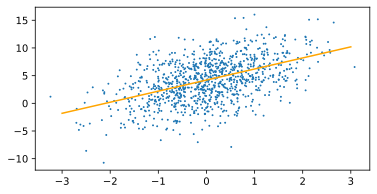

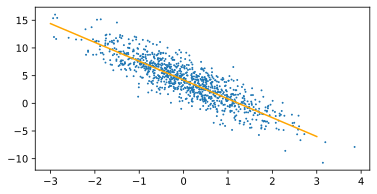

In [7]:
display.set_matplotlib_formats('svg')
# X with respect to weight one
plt.figure(figsize=(6, 3))
plt.scatter(features[:,0], labels, 1);
plt.plot(x_1,y_1,color='orange')
# X with respect to weight two
plt.figure(figsize=(6, 3))
plt.scatter(features[:,1], labels, 1);
plt.plot(x_1,y_2,color='orange')

# Linear Regression with Gradient Descent



Now that you understand the key ideas behind linear regression,
we can begin to work through a hands-on implementation in code.
In this section, **we will implement the entire method from scratch, the model, the loss function, and the gradient descent optimizer.**
While modern deep learning frameworks can automate nearly all of this work,
implementing things from scratch is the only way
to make sure that you really know what you are doing.
Moreover, when it comes time to customize models,
defining our own layers or loss functions,
understanding how things work under the hood will prove handy.

## Defining the model

First we reshape our inputs and weights. Next, we must **define our model,
relating its inputs and parameters to its outputs.**
Recall that to calculate the output of the linear model,
we simply take the matrix-vector dot product
of the input features $\mathbf{w^T}$ and the model weights $\mathbf{X}$,
and add the offset $b$ to each example.
Note that below $w^T\mathbf{X}$  is a vector and $b$ is a scalar.


$$ w^T\mathbf{X}+b$$

$$w^T\in \mathbb{R}^{1 \times 2},\space \mathbf{X}\in \mathbb{R}^{2 \times 1000}, \space b\in \mathbb{R}^{1}$$

In [8]:
X = features.T
y = labels

w = np.array([[0],[0]])
b = 0

def forward(X, w, b):
    return np.dot(w.T, X) + b

## Loss Function



We define the loss function as we previously, this time we actaully have to implement it with numpy.

$$L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

$$ L(\mathbf{w}, b)\in \mathbb{R}^{1}$$


In [9]:
def squared_loss(w,b,X, y):
  
  y_hat = forward(X, w, b)
  err = y_hat - y.reshape(y_hat.shape)
  return np.mean(np.square(err))

## Optimization

As we discussed before
linear regression has a closed-form solution.
However, this is not a course about linear regression:
it is a course about deep learning.
Since none of the other models that this book introduces
can be solved analytically, we will take this opportunity to introduce your first working example of gradient descent.

At each step we will estimate the gradient of the loss with respect to our parameters. Next, we will update our parameters in the direction that may reduce the loss.
The following code applies the  gradient descent update,
given a set of parameters and a learning rate.
The size of the update step is determined by the learning rate `lr`.
Because our loss is calculated as a sum over the entire batch,
we normalize our step size by the entire batch size,
so that the magnitude of a typical step size
does not get out of control.

## Training Loop


Now that we have all of the parts in place,
we are ready to **implement the main training loop.**
It is crucial that you understand this code
because you will see nearly identical training loops
over and over again throughout your career in deep learning.

In each iteration, we will use the entire batch of training examples,
and pass them through our model to obtain a set of predictions.
After calculating the loss, we initiate the backwards pass through the network,
storing the gradients with respect to each parameter.
Finally, we will use the gradient descent optimization algorithm 
to update the model parameters.

In summary, we will execute the following loop:

* Initialize parameters $(\mathbf{w}, b)$
* Repeat until done
    * Compute gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

In each *epoch*,
we will iterate through the entire dataset
(using the `data_iter` function) once
passing through every example in the training dataset
(assuming that the number of examples is divisible by the batch size).
The number of epochs `num_epochs` and the learning rate `lr` are both hyperparameters,

Note:

$$L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2$$

$$ \frac{\partial}{\partial \textbf{w}}L(\mathbf{w}, b)=  \frac{1}{n}\sum_{i=1}^n \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right) =  \frac{1}{n} \space \mathbf{X}(\mathbf{w^T}\mathbf{X}+b-\mathbf{y})^T$$

$$\frac{1}{n} \space \mathbf{X}(\mathbf{w^T}\mathbf{X}+b-\mathbf{y})^T\in \mathbb{R}^{2 
\times 1}$$

$$ \frac{\partial}{\partial b}L(\mathbf{w}, b)=  \frac{1}{n}\sum_{i=1}^n  \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right) =  \frac{1}{n}\sum_{i=1}^n  \left(\hat y^{(i)}- y^{(i)}\right)$$



In [10]:
lr = 0.1
loss_graph = []
w_parameter = []
for v in range(0,50):
  L = squared_loss(w,b,X,y)

  loss_graph.append(L)
  
  y_hat = forward(X,w,b)

  grad_w = 1/1000 * np.dot(X, (y_hat - y).T)
  grad_b = 1/1000 * np.sum(y_hat - y)

  w = w - lr * grad_w
  b = b - lr * grad_b

  w_parameter.append(w)

Now we can plot the loss function to see if we have successfully optimized the means square error. We will also plot the paramters $w^{1}$ and $w^{2}$ to see how they reached their correct values. 

In [11]:
w_parameter = np.array(w_parameter[1:])
w_parameter = w_parameter.reshape((len(w_parameter),2))

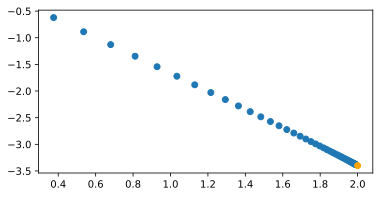

In [12]:
plt.figure(figsize=(6, 3))
plt.scatter(w_parameter[:,0],w_parameter[:,1])
plt.scatter([2],[-3.4], color = 'orange')

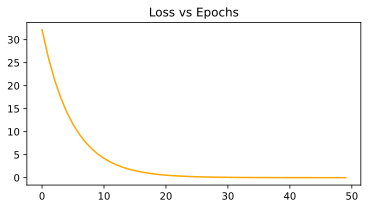

In [13]:
display.set_matplotlib_formats('svg')
plt.figure(figsize=(6, 3))
plt.title("Loss vs Epochs")
plt.plot(loss_graph,color='orange',label='Means Sqaure Loss');

Again we can create the regression line to see how they fit the data, this time remember that these values were not solved analytically.

In [14]:
x_1 = np.linspace(-3,3,num=50)
y_1 = w[0]*x_1 + b
y_2 = w[1]*x_1 + b

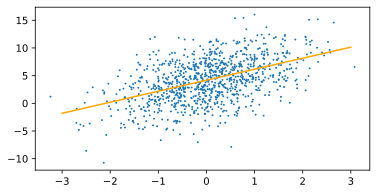

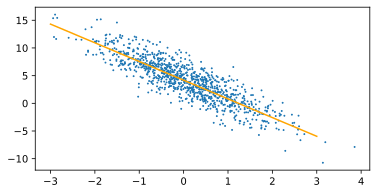

In [15]:
display.set_matplotlib_formats('svg')
# X with respect to weight one
plt.figure(figsize=(6, 3))
plt.scatter(features[:,0], labels, 1);
plt.plot(x_1,y_1,color='orange')
# X with respect to weight two
plt.figure(figsize=(6, 3))
plt.scatter(features[:,1], labels, 1);
plt.plot(x_1,y_2,color='orange')

# JAX Library

Wow that amazing, we can use gradients to fit parameter to data! In the future we won't have to calculate the gradient manually, we will use the library called JAX that calculates gradients automatically.

You can see in the code we easily calculate 
$\frac{\partial L}{\partial \mathbf{w}}$ = `jax.grad(loss_fn, 0)` and
 $\frac{\partial L}{\partial b}$ = `jax.grad(loss_fn, 1)` 

```
def loss_fn(w,b, X, y):
    err = forward(w,b, X) - y
    return jnp.mean(jnp.square(err))  # mse

gradfn_w = jax.grad(loss_fn, 0) #0 is the w parameter
gradfn_b = jax.grad(loss_fn, 1) #1 is the b parameter
```

These create function types so we then have to pass parameters throught them later on to get the numerical values needed to update $\mathbf{w}$ and $b$.

```
grad_w = gradfn_w(w,b, X, y)
grad_b = gradfn_b(w,b, X, y)

w = w - 0.1*grad_w
b = b - 0.1*grad_b
```



In [16]:
import jax
import jax.numpy as jnp

w = jnp.zeros(X.shape[:1])
b = 0.

def forward(w,b, X):
    return jnp.dot(w.T, X) + b

def loss_fn(w,b, X, y):
    err = forward(w,b, X) - y
    return jnp.mean(jnp.square(err))  # mse


gradfn_w = jax.grad(loss_fn, 0)
gradfn_b = jax.grad(loss_fn, 1)


# the main training loop
for epoch in range(50):
    loss = loss_fn(w,b, X, y)

    if epoch%5 == 0:
      print(epoch, loss)

    grad_w = gradfn_w(w,b, X, y)
    grad_b = gradfn_b(w,b, X, y)

    w = w - 0.1*grad_w
    b = b - 0.1*grad_b

print(w,b)

0 32.14403
5 3.7361574
10 0.43452194
15 0.050632622
20 0.0059778267
25 0.0007812995
30 0.00017628937
35 0.00010581685
40 9.7604236e-05
45 9.664594e-05
[ 2.0002482 -3.3997507] 4.199948


Sources: 


*   http://d2l.ai/chapter_linear-networks/index.html
*   https://www.youtube.com/channel/UCkzW5JSFwvKRjXABI-UTAkQ
*   https://coax.readthedocs.io/en/latest/examples/linear_regression/jax.html








